In [45]:
# Importing necessary modules

import os
import math
import pandas as pd
import numpy as np
import glob
from scipy import stats
import shutil
import matplotlib.pyplot as plt



# Identifying directory of lab sheets for quality screening

path = str(glob.os.getcwd())

user = path.split('\\')[2]

folder = "Lab_Sheets/"

datasheets = '/Users/' + user + '/Desktop/Coding/StandardLab/' + folder

glob.os.chdir(datasheets)



# Pulling data to navigate to completed folders in each topic folder

topic_folders = []

for x, folder, file in os.walk(datasheets):
    for loc in folder:
        topic_folders.append(loc)
        
topic_folders = [x for x in topic_folders if x != 'Completed']
topic_folders

for i in topic_folders:
    
    try:
    
        print(i)
        
        folder_name = str(i)
        
        location = "Student_Lists/Completed/"

        sheet = i + '.csv'

        id_file = '/Users/' + user + '/Desktop/Coding/StandardLab/' + location

        glob.os.chdir(id_file)

        u_id_list = pd.read_csv(sheet, header=None)

        u_id_list.columns = ['Sample_ID']

        ureides = u_id_list
        
        n_id_list = pd.read_csv(sheet, header=None)

        n_id_list.columns = ['Sample_ID']
        
        nitrates = n_id_list
        
        screened_data = datasheets + i + '/Completed'

        glob.os.chdir(screened_data)

        alldata = glob.glob(screened_data + "/*.csv")
       
        for loc in alldata:
            
            analysis = (loc.split('_')[-7])
            flag = (loc.split('_')[-11])
            name = (loc.split('\\')[-1])

            if flag != 'BAD':

                if analysis == "NIT":

                    var_id = []
                    nit_id = []
                    nit_conc = []

                    print(loc)
                    DF = pd.read_csv(loc)
                    #print(DF)

                    nit_df = DF[['Sample_ID', 'Absorbance']]

                    nit_g = nit_df.groupby('Sample_ID')

                    nit_final=nit_df.merge(nit_g.mean(),on='Sample_ID')

                    nit_final.rename(columns = {'Absorbance_x':'Each', 'Absorbance_y':'Mean'}, inplace=True)


                    # Marking values with high variance

                    sample_data_var = nit_df.merge((abs((nit_g.max() - nit_g.min())) / (nit_g.max())), on='Sample_ID')

                    sample_data_var['Type'] = DF['Type']

                    for i, row in sample_data_var.iterrows():

                        if row['Type'] == "O":

                            if float(row['Absorbance_y']) > 0.1:
                                var_id.append('x_')
                            else:
                                var_id.append('')

                    nit_final['Type'] = DF['Type']

                    nit_final['Sample_Wt(g)'] = DF['Sample_Wt(g)']

                    nit_final['Sample_Wt(g)'].replace(np.nan, 0.3, inplace= True)

                    # Creating empty lists to append with 'blanks' information

                    blanks_abs = []


                    # Identifying blank absorbances based on 'Type' column

                    for n in range(len(nit_final)):
                        if nit_final.Type[n] == 'B':
                            blanks_abs.append(float(nit_final.Each[n]))


                        # Creating a conditional to filter blank absorbances outside of acceptable range

                    good_blanks = [x for x in blanks_abs if x < 0.1 and x > -0.1]

                    blank_val = np.mean(good_blanks)

                    c=[]
                    e=[]

                    for i, row in nit_final.iterrows():

                         if row['Type'] == 'C':

                            c.append(float(row['Sample_ID']))
                            e.append(float(row['Each']))


                    slope, intercept, r_value, p_value, std_err = stats.linregress(e, c)

                    if r_value**2 < 0.95:

                            # Creating pandas dataframe for analysis

                            columns = [['Conc', 'Abs']]

                            curve = pd.DataFrame(columns = columns)


                            # Assigning values to concentration and absorbance columns

                            curve['Conc'] = c
                            curve['Abs'] = e


                            # Defining the size of the possible removal matrix

                            points = len(c) # Total number of datapoints


                            # Creating a matrix via a numpy array 

                            array = np.identity(points)


                            # Using a for-loop to generate new columns in the new pandas df containing values from decision matrix

                            for i in range(array.shape[1]):

                                curve[str(i)] = array[:,i]


                            # Appending 0's and 1's to df for all combinations of 1 and 2-point removal

                            for i in range(1,points):

                                array = np.identity(i)
                                array = np.vstack([array, [1]*i])

                                if array.shape[0] != 12:
                                    for j in range(12 - array.shape[0]):
                                        array = np.vstack([array, [0]*array.shape[1]])

                                    for k in range(array.shape[1]):

                                        curve[str(i)+str(k)+str(k)] = array[:,k]


                            # Assigning column names and creating pandas dataframe to hold/analyze "new" curve parameters

                            columns = ['Column', 'Slope', 'Intercept', 'R_Val', 'P_Val', 'StdErr']

                            columns = []
                            slopes = []
                            intercepts = []
                            rvals = []
                            pvals = []
                            stderrs = []

                            parameters = pd.DataFrame(columns = columns)


                            # Running conditional by column in new df (ONLY CONSIDERING THE COLUMNS OF THE MATRIX IN WHICH ONE POINT IS REMOVED)

                            for column in curve.iloc[:, 2:14]:

                                columns.append(column)


                                # Creating iterations counter and creating lists to append in for-loop

                                count = 0
                                conc = []
                                absorb = []


                                # Running conditional by row in column

                                for i in curve[column]: 


                                    # Conditional "removing" rows of column by not appending values to respective lists if value is 1

                                    if i < 1:
                                        conc.append(curve.iloc[count,0])
                                        absorb.append(curve.iloc[count,1])


                                    # Appending counter to reflect the next row for iteration

                                    count = count + 1


                                # Assigning variables to outputs from stats.linregress() function and appending list with column values

                                slope, inter, r_val, p_val, std = stats.linregress(conc, absorb)

                                slopes.append(slope)
                                intercepts.append(inter)
                                rvals.append(r_val**2)
                                pvals.append(p_val)
                                stderrs.append(std)


                            # Assigning regression values to columns in parameters dataframe    

                            parameters['Column'] = columns
                            parameters['Slope'] = slopes
                            parameters['Intercept'] = intercepts
                            parameters['R_Sq'] = rvals
                            parameters['P_Val'] = pvals
                            parameters['StdErr'] = stderrs


                            ## TO SEE THE PARAMETERS AND PRINT THE R^2 CALCULATED BY REMOVAL OF ONE POINT OF THE CURVE:

                            #print(parameters['R_Sq'].max())
                            #print(parameters)


                            # Creating a second conditional for r^2 based on a matrix that calculates optional r^2 values based
                            # on removal of two curve points ... THIS CODE WILL ONLY BE RUN IF THE HIGHEST POSSIBLE R^2 VALUE IN
                            # THE PREVIOUS DATAFRAME IS LESS THAN 0.95

                            if parameters['R_Sq'].max() < 0.95:


                                # OVERWRITING previous column names and dataframe to hold/analyze "new" secondary curve parameters

                                columns = ['Column', 'Slope', 'Intercept', 'R_Val', 'P_Val', 'StdErr']

                                columns = []
                                slopes = []
                                intercepts = []
                                rvals = []
                                pvals = []
                                stderrs = []

                                parameters = pd.DataFrame(columns = columns)


                                # Running conditional by column in new df (ONLY CONSIDERING THE COLUMNS OF THE MATRIX IN WHICH TWO POINTS ARE REMOVED)

                                for column in curve.iloc[:, 14:]:

                                    columns.append(column)


                                    # Creating iterations counter and creating lists to append in for-loop

                                    count = 0
                                    conc = []
                                    absorb = []


                                    # Running conditional by row in column

                                    for i in curve[column]: 


                                        # Conditional "removing" rows of column by not appending values to respective lists if value is 1

                                        if i < 1:
                                            conc.append(curve.iloc[count,0])
                                            absorb.append(curve.iloc[count,1])


                                        # Appending counter to reflect the next row for iteration    

                                        count = count + 1


                                    # Assigning variables to outputs from stats.linregress() function and appending list with column values    

                                    slope, inter, r_val, p_val, std = stats.linregress(conc, absorb)

                                    slopes.append(slope)
                                    intercepts.append(inter)
                                    rvals.append(r_val**2)
                                    pvals.append(p_val)
                                    stderrs.append(std)

                                # Assigning regression values to columns in parameters dataframe 

                                parameters['Column'] = columns
                                parameters['Slope'] = slopes
                                parameters['Intercept'] = intercepts
                                parameters['R_Sq'] = rvals
                                parameters['P_Val'] = pvals
                                parameters['StdErr'] = stderrs


                            # Displaying FINAL optimized r^2 value ... either from removing one or two points (df overwritten if two points)

                            #print(parameters.R_Sq.max())

                    nconc = []
                    nit_conc_var = []


                    for i, row in nit_final.iterrows():

                        nconc.append(((row['Mean'] - blank_val)*slope + intercept)/((row['Sample_Wt(g)']*1000/7.5)))

                    nit_final['Sample_Conc(micrmol/g)'] = nconc

                    for i, row in nit_final.iterrows():

                         if row['Type'] == 'O':

                            nit_id.append(row['Sample_ID'])
                            nit_conc.append(row['Sample_Conc(micrmol/g)'])


                    for i in range(len(nit_conc)):
                        nit_conc_var.append(str(var_id[i]) + str(nit_conc[i]))       


                    ncolumns = ['Sample_ID', 'Conc']

                    ndata = pd.DataFrame(columns = ncolumns)

                    ndata['Sample_ID'] = nit_id
                    ndata['Conc'] = nit_conc_var

                    final_nitrates = pd.merge(nitrates, ndata, on='Sample_ID', how = 'left')

                    complete_nitrates = nitrates

                    complete_nitrates[str(name)] = final_nitrates['Conc']

        
        
        for loc in alldata:

            analysis = (loc.split('_')[-7])
            flag = (loc.split('_')[-11])
            name = (loc.split('\\')[-1])

            if flag != 'BAD':
        
                if analysis == "URE":
        
                    var_id = []
                    ure_id = []
                    ure_conc = []

                    print(loc)
                    DF = pd.read_csv(loc)
                    #print(DF)

                    ure_df = DF[['Sample_ID', 'Absorbance']]

                    ure_g = ure_df.groupby('Sample_ID')

                    ure_final = ure_df.merge(ure_g.mean(),on='Sample_ID')

                    ure_final.rename(columns = {'Absorbance_x':'Each', 'Absorbance_y':'Mean'}, inplace=True)



                    # Marking values with high variance

                    sample_data_var = ure_df.merge((abs((ure_g.max() - ure_g.min())) / (ure_g.max())), on='Sample_ID')

                    sample_data_var['Type'] = DF['Type']

                    for i, row in sample_data_var.iterrows():

                        if row['Type'] == "O":

                            if float(row['Absorbance_y']) > 0.1:
                                var_id.append('x_')
                            else:
                                var_id.append('')
                  
                    ure_final['Type'] = DF['Type']

                    ure_final['Sample_Wt(g)'] = DF['Sample_Wt(g)']

                    ure_final['Sample_Wt(g)'].replace(np.nan, 0.3, inplace= True)


                    # Creating empty lists to append with 'blanks' information

                    blanks_abs = []


                    # Identifying blank absorbances based on 'Type' column

                    for n in range(len(ure_final)):
                        if ure_final.Type[n] == 'B':
                            blanks_abs.append(float(ure_final.Each[n]))


                        # Creating a conditional to filter blank absorbances outside of acceptable range

                    good_blanks = [x for x in blanks_abs if x < 0.1 and x > -0.1]

                    blank_val = np.mean(good_blanks)

                    c=[]
                    e=[]

                    for i, row in ure_final.iterrows():

                         if row['Type'] == 'C':

                            c.append(float(row['Sample_ID']))
                            e.append(float(row['Each']))

#                     print(c)
                    slope, intercept, r_value, p_value, std_err = stats.linregress(e, c)

                    if r_value**2 < 0.95:

                        # Creating pandas dataframe for analysis

                        columns = [['Conc', 'Abs']]

                        curve = pd.DataFrame(columns = columns)


                        # Assigning values to concentration and absorbance columns

                        curve['Conc'] = c
                        curve['Abs'] = e


                        # Defining the size of the possible removal matrix

                        points = len(c) # Total number of datapoints


                        # Creating a matrix via a numpy array 

                        array = np.identity(points)


                        # Using a for-loop to generate new columns in the new pandas df containing values from decision matrix

                        for i in range(array.shape[1]):

                            curve[str(i)] = array[:,i]


                        # Appending 0's and 1's to df for all combinations of 1 and 2-point removal

                        for i in range(1,points):

                            array = np.identity(i)
                            array = np.vstack([array, [1]*i])

                            if array.shape[0] != 12:
                                for j in range(12 - array.shape[0]):
                                    array = np.vstack([array, [0]*array.shape[1]])

                                for k in range(array.shape[1]):

                                    curve[str(i)+str(k)+str(k)] = array[:,k]


                        # Assigning column names and creating pandas dataframe to hold/analyze "new" curve parameters

                        columns = ['Column', 'Slope', 'Intercept', 'R_Val', 'P_Val', 'StdErr']

                        column_list = []
                        slopes = []
                        intercepts = []
                        rvals = []
                        pvals = []
                        stderrs = []

                        parameters = pd.DataFrame(columns = columns)


                        # Running conditional by column in new df (ONLY CONSIDERING THE COLUMNS OF THE MATRIX IN WHICH ONE POINT IS REMOVED)

                        for column in curve.iloc[:, 2:14]:

                            column_list.append(column)

                            #print(column_list)
                            # Creating iterations counter and creating lists to append in for-loop

                            count = 0
                            conc = []
                            absorb = []


                            # Running conditional by row in column

                            for i in curve[column_list[count]]: 


                                # Conditional "removing" rows of column by not appending values to respective lists if value is 1

                                if int(i) < 1:
#                                     print(curve.iloc[count,0])
                                    conc.append(curve.iloc[count,0])
                                    absorb.append(curve.iloc[count,1])


                                # Appending counter to reflect the next row for iteration

                                count = count + 1


                            # Assigning variables to outputs from stats.linregress() function and appending list with column values

                            slope, inter, r_val, p_val, std = stats.linregress(absorb, conc)

                            slopes.append(slope)
                            intercepts.append(inter)
                            rvals.append(r_val**2)
                            pvals.append(p_val)
                            stderrs.append(std)


                        # Assigning regression values to columns in parameters dataframe    

                        parameters['Column'] = column_list
                        parameters['Slope'] = slopes
                        parameters['Intercept'] = intercepts
                        parameters['R_Sq'] = rvals
                        parameters['P_Val'] = pvals
                        parameters['StdErr'] = stderrs


                        ## TO SEE THE PARAMETERS AND PRINT THE R^2 CALCULATED BY REMOVAL OF ONE POINT OF THE CURVE:

                        #print(parameters['R_Sq'].max())
                        #print(parameters)


                        # Creating a second conditional for r^2 based on a matrix that calculates optional r^2 values based
                        # on removal of two curve points ... THIS CODE WILL ONLY BE RUN IF THE HIGHEST POSSIBLE R^2 VALUE IN
                        # THE PREVIOUS DATAFRAME IS LESS THAN 0.95

                        if parameters['R_Sq'].max() < 0.95:


                            # OVERWRITING previous column names and dataframe to hold/analyze "new" secondary curve parameters

                            columns = ['Column', 'Slope', 'Intercept', 'R_Val', 'P_Val', 'StdErr']

                            column_list = []
                            slopes = []
                            intercepts = []
                            rvals = []
                            pvals = []
                            stderrs = []

                            parameters = pd.DataFrame(columns = columns)


                            # Running conditional by column in new df (ONLY CONSIDERING THE COLUMNS OF THE MATRIX IN WHICH TWO POINTS ARE REMOVED)

                            for column in curve.iloc[:, 14:]:

                                column_list.append(column)


                                # Creating iterations counter and creating lists to append in for-loop

                                count = 0
                                conc = []
                                absorb = []


                                # Running conditional by row in column

                                for i in curve[column_list[count]]: 


                                    # Conditional "removing" rows of column by not appending values to respective lists if value is 1

                                    if int(i) < 1:
#                                         print(curve.iloc[count,0])
                                        conc.append(curve.iloc[count,0])
                                        absorb.append(curve.iloc[count,1])


                                    # Appending counter to reflect the next row for iteration    

                                    count = count + 1


                                # Assigning variables to outputs from stats.linregress() function and appending list with column values    

                                slope, inter, r_val, p_val, std = stats.linregress(absorb, conc)

                                slopes.append(slope)
                                intercepts.append(inter)
                                rvals.append(r_val**2)
                                pvals.append(p_val)
                                stderrs.append(std)

                            # Assigning regression values to columns in parameters dataframe 

                            parameters['Column'] = column_list
                            parameters['Slope'] = slopes
                            parameters['Intercept'] = intercepts
                            parameters['R_Sq'] = rvals
                            parameters['P_Val'] = pvals
                            parameters['StdErr'] = stderrs


                        # Displaying FINAL optimized r^2 value ... either from removing one or two points (df overwritten if two points)

                        #print(parameters.R_Sq.max())
                    
#                         print(conc)
#                         print(absorb)
#                     print(slope)
#                     print(intercept)
                    
                    conc = []
                    ure_conc_var = []

                    for i, row in ure_final.iterrows():

                        conc.append((((row['Mean'] - blank_val)*slope + intercept)/((row['Sample_Wt(g)']*1000/7.5)))*4)

                    ure_final['Sample_Conc(micrmol/g)'] = conc



                    for i, row in ure_final.iterrows():

                        if row['Type'] == 'O':

                            ure_id.append(row['Sample_ID'])
                            ure_conc.append(row['Sample_Conc(micrmol/g)'])

                    for i in range(len(ure_conc)):
                        ure_conc_var.append(str(var_id[i]) + str(ure_conc[i]))

                    columns = ['Sample_ID', 'Conc']

                    udata = pd.DataFrame(columns = columns)

                    udata['Sample_ID'] = ure_id
                    udata['Conc'] = ure_conc_var 

                    final_ureides = pd.merge(ureides, udata, on='Sample_ID', how = 'left')  

                    complete_ureides = ureides

                    complete_ureides[str(name)] = final_ureides['Conc']
                
                    print(glob.os.getcwd())
                    
                    
        study_name = str(folder_name.split('_')[-3]) + "_" + str(folder_name.split('_')[-1])
        
        
        # Creating new folder for saving results from each study
        
        result_folder = '/Users/' + user + '/Desktop/Coding/StandardLab/Results/' + study_name
    
        if not glob.os.path.exists(result_folder):
            glob.os.makedirs(result_folder)
        

        glob.os.chdir(result_folder)
        
        complete_ureides.to_csv('Results_URE_' + folder_name + '.csv', index=False)
        complete_nitrates.to_csv('Results_NIT_' + folder_name + '.csv', index=False)
        
    
    except FileNotFoundError:
        continue
        
    
### CURRENT ROADBLOCK - Moving folder to different folder    
    
    
    # Creating new folder for processed datasheets, to avoid multiple runs of same data
            
#     processed_folder = '/Users/' + user + '/Desktop/Coding/StandardLab/Lab_Sheets/0_RAU_Processed_Sheets/'
    
#     if not glob.os.path.exists(processed_folder):
#         glob.os.makedirs(processed_folder)
        
        
#     glob.os.chdir(processed_folder)
    
#     # Moving location folder to processed folder to avoid re-running
            
#     shutil.move(str(folder_name), (processed_folder + folder_name + '/'))

0_RAU_Processed_Sheets
LMR_IA_USB
/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/LMR_IA_USB/Completed\A_1_NIT_LMR_IA_USB_03_05_19.csv
/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/LMR_IA_USB/Completed\A_2_NIT_LMR_IA_USB_03_01_19.csv
/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/LMR_IA_USB/Completed\B_1_NIT_LMR_IA_USB_03_01_19.csv
/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/LMR_IA_USB/Completed\C_1_NIT_LMR_IA_USB_00_00_00.csv
/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/LMR_IA_USB/Completed\D_1_NIT_LMR_IA_USB_03_05_19.csv
/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/LMR_IA_USB/Completed\E_1_NIT_LMR_IA_USB_03_06_19.csv
/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/LMR_IA_USB/Completed\F_1_NIT_LMR_IA_USB_03_06_19.csv
/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/LMR_IA_USB/Completed\A_1_URE_LMR_IA_USB_02_27_19.csv
C:\Users\rveenstra\Desktop\Coding\StandardLab\Lab_Sheets\LMR_IA_USB\Completed
/Users/rveenstra/Desktop

1783.3768310960802
-38.870968975205415
0.9991654192493664


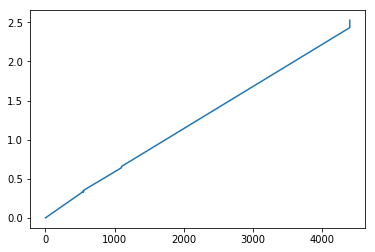

      Sample_ID   Each      Mean Type  Sample_Wt(g)
0           1_1  0.012  0.012000    B           NaN
1           1_2  0.018  0.018000    B           NaN
2           2_1  0.008  0.008000    B           NaN
3           2_2  0.008  0.008000    B           NaN
4             0  0.004  0.003000    C           NaN
5             0  0.003  0.003000    C           NaN
6             0  0.002  0.003000    C           NaN
7   549.5825955  0.341  0.342333    C           NaN
8   549.5825955  0.333  0.342333    C           NaN
9   549.5825955  0.353  0.342333    C           NaN
10  1099.165191  0.643  0.650000    C           NaN
11  1099.165191  0.648  0.650000    C           NaN
12  1099.165191  0.659  0.650000    C           NaN
13  4396.660764  2.432  2.479000    C           NaN
14  4396.660764  2.526  2.479000    C           NaN
15      LIF-475  2.064  2.003000    O           0.3
16      LIF-475  1.942  2.003000    D           0.3
17      LIF-476  0.858  0.854500    O           0.3
18      LIF-

,ID,CONC
0,LIF-475,351.272399
1,LIF-476,146.451570
2,LIF-477,184.080821
3,LIF-478,276.281403
4,LIF-479,197.545316
5,LIF-480,179.176535
6,LIF-481,478.694674
7,LIF-482,251.670803
8,LIF-483,170.794664
9,LIF-484,165.979546


In [34]:
import pandas as pd
import glob
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

file = '/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/MS_OTT_LI/Completed/'

glob.os.chdir(file)

df = pd.read_csv('A_4_URE_MS_OTT_LI_11_28_18edited.csv')

curve = []
c_id = []
blanks = []


for i, row in df.iterrows():
    if row['Type'] == 'C':
        curve.append(float(row['Absorbance']))
        c_id.append(float(row['Sample_ID']))
        
    elif row['Type'] == 'B':
        blanks.append(float(row['Absorbance']))
        
slope, intercept, r_value, p_value, std_err = stats.linregress(curve, c_id)
print(slope)
print(intercept)
print(r_value**2)

plt.plot(c_id, curve)

plt.show()

blank_val = np.mean(blanks)

ure_df = df[['Sample_ID', 'Absorbance']]

        
# Each sample has duplicate readings, so data must be grouped by sample ID

ure_g = ure_df.groupby('Sample_ID')


# Creating a dataframe with the mean of each "sample group" and 
# merging with copied dataframe based on ID ... this creates two
# columns with absorbance data - one with the original reading, and
# the other with the overall mean from that sample.

ure_final=ure_df.merge(ure_g.mean(),on='Sample_ID')


# Renaming columns for easy manipulation

ure_final.rename(columns = {'Absorbance_x':'Each', 'Absorbance_y':'Mean'}, inplace=True)


# Pulling other necessary calculation data from original dataframe

ure_final['Type'] = df['Type']
ure_final['Sample_Wt(g)'] = df['Sample_Wt(g)']

print(ure_final)
u_final_conc = []
u_final_id = []


for i, row in ure_final.iterrows():
    if row['Type'] == 'O':


        # Appending the nitrates master list with both the calculated concentration
        # and the corresponding sample ID information

        u_final_conc.append(((row['Mean'] - blank_val)*slope + intercept)/((row['Sample_Wt(g)']*1000)/7.5)*4)
        u_final_id.append(row['Sample_ID'])
        
columns = ['ID', 'CONC']
u_complete = pd.DataFrame(columns = columns)

u_complete['ID'] = u_final_id
u_complete['CONC'] = u_final_conc

u_complete

1731.2406921071158
-30.029158581035517
0.9995778602536864


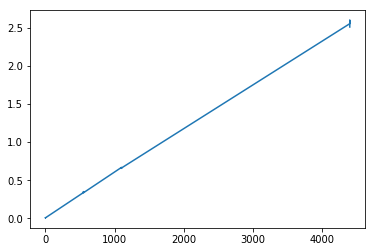

      Sample_ID   Each      Mean Type  Sample_Wt(g)
0           1_1  0.011  0.011000    B           NaN
1           1_2  0.008  0.008000    B           NaN
2           2_1  0.008  0.008000    B           NaN
3           2_2  0.013  0.013000    B           NaN
4             0  0.007  0.006000    C           NaN
5             0  0.005  0.006000    C           NaN
6             0  0.006  0.006000    C           NaN
7   549.5825955  0.338  0.341000    C           NaN
8   549.5825955  0.350  0.341000    C           NaN
9   549.5825955  0.335  0.341000    C           NaN
10  1099.165191  0.668  0.661000    C           NaN
11  1099.165191  0.655  0.661000    C           NaN
12  1099.165191  0.660  0.661000    C           NaN
13  4396.660764  2.553  2.553333    C           NaN
14  4396.660764  2.598  2.553333    C           NaN
15  4396.660764  2.509  2.553333    C           NaN
16      LIF-391  0.474  0.468000    O           0.3
17      LIF-391  0.462  0.468000    D           NaN
18      LIF-

,ID,CONC
0,LIF-391,76.287908
1,LIF-392,63.390165
2,LIF-393,54.214589
3,LIF-394,95.850928
4,LIF-395,41.230284
5,LIF-396,74.296981
6,LIF-397,87.367848
7,LIF-398,84.511301
8,LIF-399,77.846024
9,LIF-400,18.724155


In [31]:
import pandas as pd
import glob
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

file = '/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/MS_OTT_LI/Completed/'

glob.os.chdir(file)

df = pd.read_csv('A_1_URE_MS_OTT_LI_11_21_18.csv')

curve = []
c_id = []
blanks = []


for i, row in df.iterrows():
    if row['Type'] == 'C':
        curve.append(float(row['Absorbance']))
        c_id.append(float(row['Sample_ID']))
        
    elif row['Type'] == 'B':
        blanks.append(float(row['Absorbance']))
        
slope, intercept, r_value, p_value, std_err = stats.linregress(curve, c_id)
print(slope)
print(intercept)
print(r_value**2)

plt.plot(c_id, curve)

plt.show()

blank_val = np.mean(blanks)

ure_df = df[['Sample_ID', 'Absorbance']]

        
# Each sample has duplicate readings, so data must be grouped by sample ID

ure_g = ure_df.groupby('Sample_ID')


# Creating a dataframe with the mean of each "sample group" and 
# merging with copied dataframe based on ID ... this creates two
# columns with absorbance data - one with the original reading, and
# the other with the overall mean from that sample.

ure_final=ure_df.merge(ure_g.mean(),on='Sample_ID')


# Renaming columns for easy manipulation

ure_final.rename(columns = {'Absorbance_x':'Each', 'Absorbance_y':'Mean'}, inplace=True)


# Pulling other necessary calculation data from original dataframe

ure_final['Type'] = df['Type']
ure_final['Sample_Wt(g)'] = df['Sample_Wt(g)']

print(ure_final)
u_final_conc = []
u_final_id = []


for i, row in ure_final.iterrows():
    if row['Type'] == 'O':


        # Appending the nitrates master list with both the calculated concentration
        # and the corresponding sample ID information

        u_final_conc.append((((row['Mean'] - blank_val)*slope + intercept)/((row['Sample_Wt(g)']*1000/7.5)))*4)
        u_final_id.append(row['Sample_ID'])
        
columns = ['ID', 'CONC']
u_complete = pd.DataFrame(columns = columns)

u_complete['ID'] = u_final_id
u_complete['CONC'] = u_final_conc

u_complete

In [86]:
# Importing necessary modules

import os
import math
import pandas as pd
import numpy as np
import glob
from itertools import cycle
import matplotlib.pyplot as plt
from scipy import stats
import shutil



# Identifying directory of lab sheets for quality screening

path = str(glob.os.getcwd())

user = path.split('\\')[2]

folder = "Lab_Sheets/"

datasheets = '/Users/' + user + '/Desktop/Coding/StandardLab/' + folder

glob.os.chdir(datasheets)



# Setting loop for iterating through files WITHIN folders IN the specified folder

for x, folder, file in os.walk(datasheets):
    
    
    # Using "try" loop in the event that a folder is empty
    
    try: 
        
        
        # Looping through every file in a folder
        
        for loc in folder:
            
            
            # Identifying working folder
            
            print(loc)

            folder_loc = datasheets + loc

            glob.os.chdir(folder_loc)
            
            
            # Grabbing all csv files in specified folder

            all_datasheets = glob.glob(folder_loc + "/*.csv")
            
            
            # Creating empty lists to append with ID's that fail quality screening

            N_Re_Run = []
            U_Re_Run = []
            
            
            # Screening each sheet individually

            for sheet in all_datasheets:

                
                # Reading working file as dataframe in pandas
                
                lab_data = pd.read_csv(sheet)
                
                
                # Pulling parts of name to identify sheet for naming/moving

                sheet_name = sheet.split('\\')[-1]
                title = sheet_name.split('_')[2]
            
            
                # Checking for data - skipping remainder of code (breaking loop) if there is no data

                if np.isnan(lab_data.Absorbance[0]):
                    break

                
                # Continuing if data is found

                else:
                    
                    # Identifying sheet
                    
                    print(sheet)


                    # Creating empty lists to append with 'blanks' information
                    
                    blanks_abs = []

                    
                    # Identifying blank absorbances based on 'Type' column
                    
                    for n in range(len(lab_data)):
                        if lab_data.Type[n] == 'B':
                            blanks_abs.append(float(lab_data.Absorbance[n]))
                            
                  
                    # Creating a conditional to filter blank absorbances outside of acceptable range
                            
                    good_blanks = [x for x in blanks_abs if x < 0.1 and x > -0.1]
                    
                    
                    # If the list of acceptable blanks has fewer than three values, set must be repeated
                    if len(good_blanks) <= 2 :
                        print('oops')
                    else:
                        continue
    except:
        continue

MR_USB
RV_CTS
/Users/rveenstra/Desktop/Coding/StandardLab/Lab_Sheets/RV_CTS\A_1_URE_RV_CTS_00_00_00.csv
oops
USB_Indiana
USB_Iowa
USB_Minnesota
USB_South_Dakota
Completed
Completed
Completed
Completed
Completed
Completed


In [36]:
columns = ['Conc', 'Abs']

curve = pd.DataFrame(columns = columns)

curve['Conc'] = curve_concentration
curve['Abs'] = curve_absorbance

points = len(curve_concentration) # Total number

array = np.identity(points)

for i in range(array.shape[1]):

    curve[str(i)] = array[:,i]

for i in range(1,points):

    array = np.identity(i)
    array = np.vstack([array, [1]*i])

    if array.shape[0] != 12:
        for j in range(12 - array.shape[0]):
            array = np.vstack([array, [0]*array.shape[1]])

        for k in range(array.shape[1]):

            curve[str(i)+str(k)+str(k)] = array[:,k]
columns = ['Column', 'Slope', 'Intercept', 'R_Val', 'P_Val', 'StdErr']

columns = []
slopes = []
intercepts = []
rvals = []
pvals = []
stderrs = []

parameters = pd.DataFrame(columns = columns)

for column in curve.iloc[:, 2:14]:
    
    columns.append(column)
    
    count = 0
    conc = []
    absorb = []
    
    
    for i in curve[column]: 
        if i < 1:
            conc.append(curve.iloc[count,0])
            absorb.append(curve.iloc[count,1])
        count = count + 1
        
    slope, inter, r_val, p_val, std = stats.linregress(conc, absorb)
    
    slopes.append(slope)
    intercepts.append(inter)
    rvals.append(r_val**2)
    pvals.append(p_val)
    stderrs.append(std)

parameters['Column'] = columns
parameters['Slope'] = slopes
parameters['Intercept'] = intercepts
parameters['R_Sq'] = rvals
parameters['P_Val'] = pvals
parameters['StdErr'] = stderrs

print(parameters.R_Sq.max())

if parameters['R_Sq'].max() < 0.90:
    
    columns = ['Column', 'Slope', 'Intercept', 'R_Val', 'P_Val', 'StdErr']

    columns = []
    slopes = []
    intercepts = []
    rvals = []
    pvals = []
    stderrs = []

    parameters = pd.DataFrame(columns = columns)

    for column in curve.iloc[:, 14:]:

        columns.append(column)
        
        count = 0
        conc = []
        absorb = []


        for i in curve[column]: 
            if i < 1:
                conc.append(curve.iloc[count,0])
                absorb.append(curve.iloc[count,1])
            count = count + 1

        slope, inter, r_val, p_val, std = stats.linregress(conc, absorb)

        slopes.append(slope)
        intercepts.append(inter)
        rvals.append(r_val**2)
        pvals.append(p_val)
        stderrs.append(std)
    #     print(conc)
    #     print(r_val**2)
    parameters['Column'] = columns
    parameters['Slope'] = slopes
    parameters['Intercept'] = intercepts
    parameters['R_Sq'] = rvals
    parameters['P_Val'] = pvals
    parameters['StdErr'] = stderrs
    
parameters

0.8587038805948787


,Column,Slope,Intercept,R_Sq,P_Val,StdErr
0,100,0.000354,-0.245000,0.581206,0.010353,0.000106
1,200,0.000342,-0.201250,0.556845,0.013184,0.000108
2,211,0.000354,-0.245000,0.581206,0.010353,0.000106
3,300,0.000319,-0.110909,0.578776,0.010612,0.000096
4,311,0.000328,-0.144793,0.597123,0.008779,0.000095
5,322,0.000319,-0.110909,0.578776,0.010612,0.000096
6,400,0.000320,-0.114876,0.579201,0.010566,0.000096
7,411,0.000329,-0.148760,0.597592,0.008736,0.000095
8,422,0.000320,-0.114876,0.579201,0.010566,0.000096
9,433,0.000306,-0.055556,0.604321,0.008133,0.000088
